In [ ]:
# @title Importing Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import random
import re
import string
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, BatchNormalization, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from keras.callbacks import ModelCheckpoint
# Transformers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# @title Loading Data
training_data = pd.read_csv('/content/training.csv')
test_data = pd.read_csv('/content/test.csv')
validation_data = pd.read_csv('/content/validation.csv')

# Preporcessing


In [ ]:
training_data.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


In [ ]:
training_data.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


In [ ]:
training_data.shape[0]

16000

In [ ]:
training_data.shape[1]

2

In [ ]:
print("Duplicate entries in the dataset: " + str(training_data.duplicated().sum()))

Duplicate entries in the dataset: 1


In [ ]:
training_data = training_data.drop_duplicates()


Mapping Labels to Emotions

In [ ]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
training_data['description'] = training_data['label'].map(labels_dict )
training_data.head()

<ipython-input-54-fdddb3a3498c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['description'] = training_data['label'].map(labels_dict )


,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [ ]:
training_data.groupby(["description","label"]).size()

description  label
anger        3        2159
fear         4        1937
joy          1        5361
love         2        1304
sadness      0        4666
surprise     5         572
dtype: int64


Plotting Emotion Distribution

<Axes: xlabel='description'>

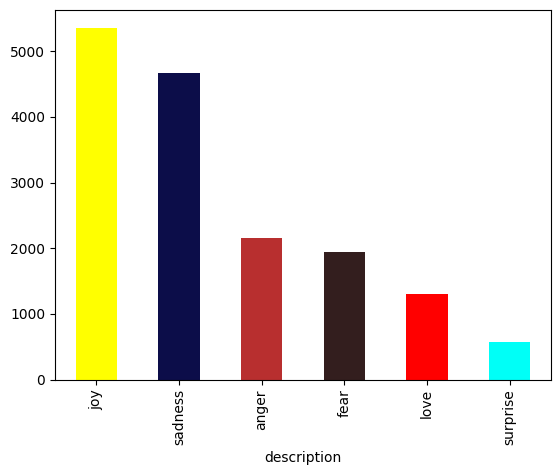

In [ ]:
training_data["description"].value_counts().plot(kind='bar',color=['yellow', '#0c0d49', '#b82f2f', '#331e1e', 'red','#00fff7'])

Downloading NLTK Resources

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

preprocesses the text data by removing non-alphabetic characters, converting text to lowercase, removing stopwords, and lemmatizing the words. The preprocessed text is then stored in the train, validation, and test lists.

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Convert to lowercase and split into words
    words = text.lower().split()

    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Join the words back into a single string
    return ' '.join(words)

# Apply the preprocessing function to each text in training_data['text']
train = [preprocess_text(text) for text in training_data['text']]
validation=[preprocess_text(text) for text in validation_data['text']]
test=[preprocess_text(text) for text in test_data['text']]


In [ ]:
train

['didnt feel humiliated',
 'go feeling hopeless damned hopeful around someone care awake',
 'im grabbing minute post feel greedy wrong',
 'ever feeling nostalgic fireplace know still property',
 'feeling grouchy',
 'ive feeling little burdened lately wasnt sure',
 'ive taking milligram time recommended amount ive fallen asleep lot faster also feel like funny',
 'feel confused life teenager jaded year old man',
 'petronas year feel petronas performed well made huge profit',
 'feel romantic',
 'feel like make suffering seeing mean something',
 'feel running divine experience expect type spiritual encounter',
 'think easiest time year feel dissatisfied',
 'feel low energy thirsty',
 'immense sympathy general point possible proto writer trying find time write corner life sign agent let alone publishing contract feel little precious',
 'feel reassured anxiety side',
 'didnt really feel embarrassed',
 'feel pretty pathetic time',
 'started feeling sentimental doll child began collection vint

In [ ]:
validation

['im feeling quite sad sorry ill snap soon',
 'feel like still looking blank canvas blank piece paper',
 'feel like faithful servant',
 'feeling cranky blue',
 'treat feeling festive',
 'start feel appreciative god done',
 'feeling confident able take care baby',
 'feel incredibly lucky able talk',
 'feel le keen army every day',
 'feel dirty ashamed saying',
 'feel bitchy defeated yet',
 'dribbling mum coffee table looking window feeling happy',
 'woke often got around feeling pukey radiation groggy',
 'feeling sentimental',
 'walked hour fifteen minute later feeling like beaten stick placed rack stretched',
 'never stop feeling thankful compare others considered lucky encounter ruthless pirate witness slaughter others',
 'feel abused quite honestly made day little better',
 'know feel like stressed glaring squeezed soap onto sponge',
 'also loved could really feel desperation sequence especially liked emotion knight squire theyve together similar fashion batman robin long time',
 'lu

In [ ]:
test

['im feeling rather rotten im ambitious right',
 'im updating blog feel shitty',
 'never make separate ever want feel like ashamed',
 'left bouquet red yellow tulip arm feeling slightly optimistic arrived',
 'feeling little vain one',
 'cant walk shop anywhere feel uncomfortable',
 'felt anger end telephone call',
 'explain clung relationship boy many way immature uncommitted despite excitement feeling getting accepted master program university virginia',
 'like breathless feeling reader eager see happen next',
 'jest feel grumpy tired pre menstrual probably week im fit walrus vacation summer',
 'feel particularly agitated',
 'feel beautifully emotional knowing woman knew handful holding baba journey',
 'pay attention deepens feeling invaded helpless',
 'feel extremely comfortable group people dont even need hide',
 'find odd position feeling supportive',
 'feeling heartbroken im sure katniss',
 'feel little mellow today',
 'feel like role would tear sail pessimism discontent',
 'feel 

TF-IDF Vectorization

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
# Fit and transform the corpus
x_train = tfidf_vectorizer.fit_transform(train)
x_val=tfidf_vectorizer.transform(validation)
x_test=tfidf_vectorizer.transform(test)


Extracting Labels

In [ ]:
y_train=training_data['label']
y_val=validation_data['label']
y_test=test_data['label']

Applying Preprocessing to Text Data

In [ ]:
training_data["clean_text"] = training_data["text"].apply(preprocess_text)

In [ ]:
test_data["clean_text"] = test_data["text"].apply(preprocess_text)

In [ ]:
validation_data["clean_text"] = validation_data["text"].apply(preprocess_text)

Extracting Cleaned Text

In [ ]:
X_val = validation_data["clean_text"].values
X_tr = training_data["clean_text"].values
X_te = test_data["clean_text"].values


Tokenizer is initialized with a maximum vocabulary size of 16000 words. It is then fit on the cleaned training text. Sequences of tokens are created for the training, validation, and test sets using the tokenizer's texts_to_sequences method. These sequences are then padded to a maximum sequence length of 250 using the pad_sequences function. This prepares the text data for input into a neural network model.

In [ ]:
tokenizer = Tokenizer(num_words=16000)
tokenizer.fit_on_texts(X_tr)

max_seq_length = 250

X_tr_seq = tokenizer.texts_to_sequences(X_tr)
X_tr_seq = pad_sequences(X_tr_seq, maxlen=max_seq_length)

X_va_seq = tokenizer.texts_to_sequences(X_val)
X_va_seq = pad_sequences(X_va_seq, maxlen=max_seq_length)

X_te_seq = tokenizer.texts_to_sequences(X_te)
X_te_seq = pad_sequences(X_te_seq, maxlen=max_seq_length)


Combining Text Data To Use It In Specific Model

In [ ]:
all_list = training_data['text'].tolist() + test_data['text'].tolist() + validation_data['text'].tolist()

 a Tokenizer is used to tokenize the words in all_list, which contains all the text data. The number of unique words is then printed. Next, a PorterStemmer is used to stem each word in the vocabulary. The stemmed words are tokenized again, and the number of unique stemmed words is printed. This process shows the effect of stemming on reducing the vocabulary size by grouping words with similar stems.

In [ ]:
from nltk.stem import PorterStemmer
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(all_list)
word_index1 = tokenizer1.word_index

print("Nombre of words without Stemming:",len(word_index1))

stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in word_index1.keys()]

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(stemmed_words)
word_index2 = tokenizer2.word_index

print("Nombre of words with Stemming:",len(word_index2))

Nombre of words without Stemming: 17096
Nombre of words with Stemming: 11705


preprocesses text data by splitting the text into words, stemming each word, converting the stemmed words into tokens using tokenizer2, and appending the token list along with the label to a new list. The output is a list of tokenized text data paired with their labels.

In [ ]:
def preprocess_data(data):
    new_data = []
    for index, row in data.iterrows():
        test_split = row['text'].split()
        stemmed_words2 = [stemmer.stem(word) for word in test_split]
        token_list= tokenizer2.texts_to_sequences([stemmed_words2])[0]
        new_data.append([token_list,row['label']])
    return new_data

In [ ]:
new_train_data = preprocess_data(training_data)
print(training_data['text'][0])
print(new_train_data[0])

i didnt feel humiliated
[[3198, 3265, 220, 665], 0]


In [ ]:
new_val_data = preprocess_data(validation_data)
print(validation_data['text'][0])
print(new_val_data[0])

im feeling quite sad and sorry for myself but ill snap out of it soon
[[3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380], 0]


 Splitting into train_X and train_y

In [ ]:
train_X = [row[0] for row in new_train_data]
train_y = [row[1] for row in new_train_data]

# Print the results
print("train_X:", train_X[0])
print("train_y:", train_y[0])

train_X: [3198, 3265, 220, 665]
train_y: 0


Splitting into val_X and val_y

In [ ]:
val_X = [row[0] for row in new_val_data]
val_y = [row[1] for row in new_val_data]

print("train_X:", val_X[0])
print("train_y:", val_y[0])

train_X: [3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380]
train_y: 0



Calculating Length of Longest Sentence

In [ ]:
length_of_longest_sentence = len(max(train_X, key=len))
print(length_of_longest_sentence)
print(max(train_X, key=len))

66
[3198, 613, 3250, 3588, 3217, 3204, 3198, 927, 3245, 1497, 3245, 1354, 3217, 3245, 1303, 1296, 3200, 2107, 1284, 1276, 3220, 220, 3598, 3213, 220, 1276, 3528, 3217, 7890, 4263, 3221, 5568, 1552, 3243, 3198, 4263, 3221, 1552, 5569, 5569, 3198, 3579, 5568, 3198, 7891, 1276, 3200, 3202, 1293, 3219, 1401, 3948, 3598, 3213, 3223, 239, 3528, 3213, 85, 3267, 579, 1658, 3206, 3201, 239, 1289]


These loops pad the sequences in train_X and val_X with zeros to match the length of the longest sentence. This ensures that all sequences have the same length for modeling purposes.

In [ ]:
for i in range(len(train_X)):
    for j in range(length_of_longest_sentence-len(train_X[i])):
        train_X[i].append(0)

for i in range(len(val_X)):
    for j in range(length_of_longest_sentence-len(val_X[i])):
        val_X[i].append(0)


Converting to NumPy Arrays

In [ ]:
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)

print(train_X.shape,train_y.shape)
print(val_X.shape,val_y.shape)

(15999, 66) (15999,)
(2000, 66) (2000,)



Converting Labels to One-Hot Encoding



In [ ]:
from keras.utils import to_categorical
# Convert labels to one-hot encoding
train_y_one_hot = to_categorical(train_y, num_classes=16000)
val_y_one_hot = to_categorical(val_y, num_classes=16000)

# Modeling

defines a deep learning model using Keras for text classification. It includes an embedding layer, a 1D convolutional layer, max pooling, bidirectional LSTM layers, batch normalization, dropout for regularization, dense layers, and an output layer. The model is designed for multi-class classification tasks on text data.

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=250))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=128)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=6, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate = 1e-4),
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy']
                 )

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 128)          2560000   
                                                                 
 conv1d_1 (Conv1D)           (None, 248, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 124, 64)           0         
 g1D)                                                            
                                                                 
 bidirectional_2 (Bidirecti  (None, 124, 128)          66048     
 onal)                                                           
                                                                 
 batch_normalization_3 (Bat  (None, 124, 128)          512       
 chNormalization)                                                
                                                      

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
print(type(x_train))
print(type(y_train))

<class 'scipy.sparse._csr.csr_matrix'>
<class 'pandas.core.series.Series'>


In [ ]:
history = model.fit(X_tr_seq,
                    y_train,
                    validation_data=(X_va_seq, y_val),
                    batch_size=64,
                    epochs=15,
                    verbose=1,
                    callbacks=[checkpoint]  # Use the checkpoint callback to save the best model
                   )

Epoch 1/15
250/250 [==============================] - ETA: 0s - loss: 2.2193 - accuracy: 0.1990
Epoch 1: val_accuracy improved from -inf to 0.04050, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 281s 1s/step - loss: 2.2193 - accuracy: 0.1990 - val_loss: 1.8887 - val_accuracy: 0.0405
Epoch 2/15
250/250 [==============================] - ETA: 0s - loss: 1.6611 - accuracy: 0.3755
Epoch 2: val_accuracy improved from 0.04050 to 0.49900, saving model to best_model.h5
250/250 [==============================] - 269s 1s/step - loss: 1.6611 - accuracy: 0.3755 - val_loss: 1.5649 - val_accuracy: 0.4990
Epoch 3/15
250/250 [==============================] - ETA: 0s - loss: 1.0282 - accuracy: 0.6425
Epoch 3: val_accuracy improved from 0.49900 to 0.65900, saving model to best_model.h5
250/250 [==============================] - 266s 1s/step - loss: 1.0282 - accuracy: 0.6425 - val_loss: 1.0227 - val_accuracy: 0.6590
Epoch 4/15
250/250 [==============================] - ETA: 0s - loss: 0.6280 - accuracy: 0.7941
Epoch 4: val_accuracy improved from 0.65900 to 0.72250, saving model to best_model.h5
250/250 [==============================] - 275s 1s/step - 

In [ ]:
from keras.models import load_model
best_model = load_model('best_model.h5')

In [ ]:
test_loss, test_acc = best_model.evaluate(X_te_seq,y_test)

print('Validation loss:', test_loss)
print('Validation accuracy:', test_acc)

63/63 [==============================] - 15s 199ms/step - loss: 0.6995 - accuracy: 0.8200
Validation loss: 0.699539303779602
Validation accuracy: 0.8199999928474426


In [ ]:
predictions = [np.argmax(i) for i in best_model.predict(X_te_seq)]

63/63 [==============================] - 15s 206ms/step


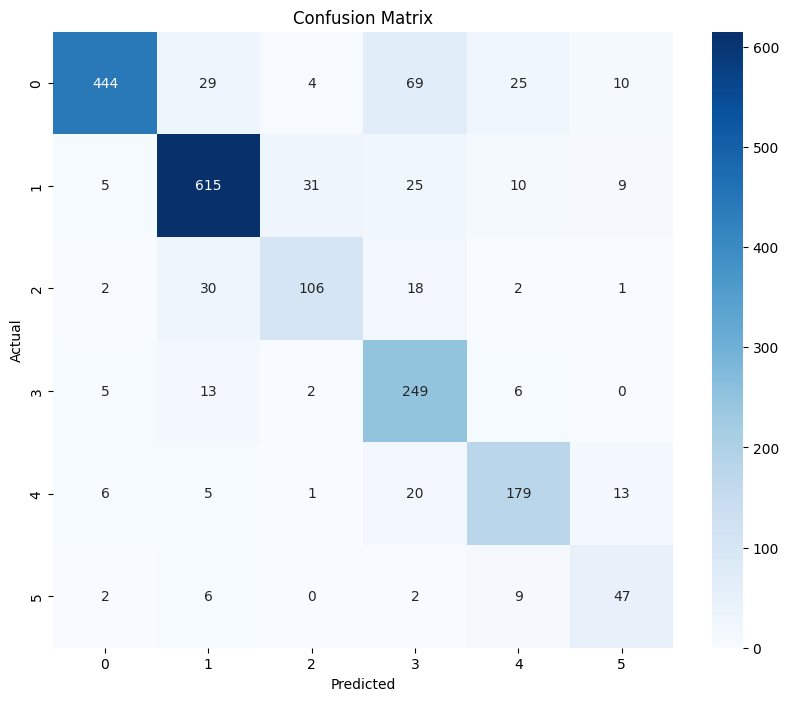

In [ ]:
# Compute confusion matrix
cm_raw = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Create the Logistic Regression model
logistic_regression = LogisticRegression()

# Train the model on training data
logistic_regression.fit(x_train, y_train)

# Predict on validation data
y_pred_val = logistic_regression.predict(x_val)

# Evaluate on validation data
accuracy_val = accuracy_score(y_val, y_pred_val)
report_val = classification_report(y_val, y_pred_val)

print("Validation Accuracy:", accuracy_val)
print("Validation Classification Report:\n", report_val)

Validation Accuracy: 0.875
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       550
           1       0.86      0.95      0.90       704
           2       0.89      0.71      0.79       178
           3       0.90      0.83      0.86       275
           4       0.87      0.77      0.82       212
           5       0.91      0.59      0.72        81

    accuracy                           0.88      2000
   macro avg       0.88      0.80      0.83      2000
weighted avg       0.88      0.88      0.87      2000



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
y_pred_test = logistic_regression.predict(x_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)


Test Accuracy: 0.872


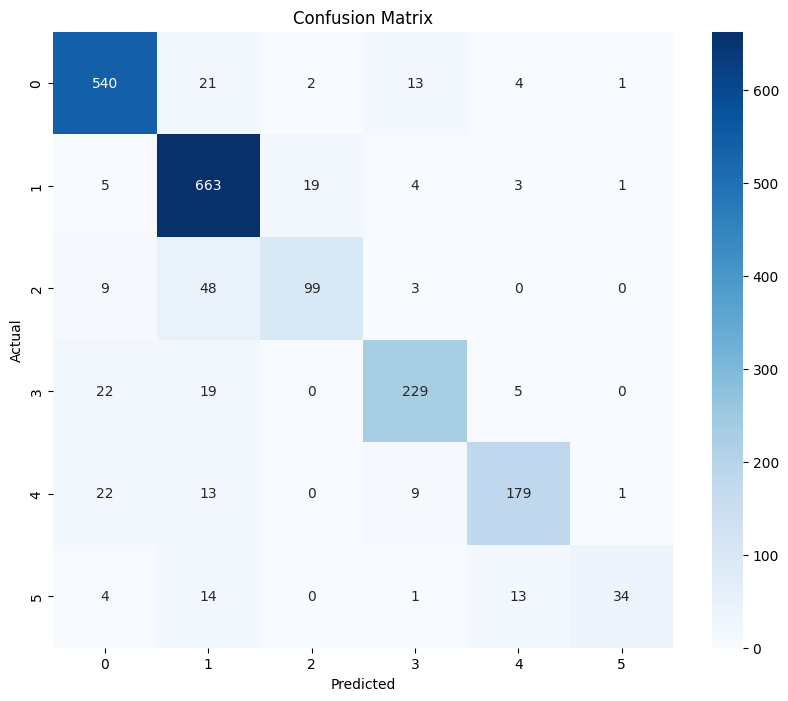

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Compute confusion matrix
cm_raw = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Import the SVM classifier
from sklearn.svm import SVC

# Create the SVM model
svm_classifier = SVC(kernel='linear')

# Train the model using the training data
svm_classifier.fit(x_train, y_train)

# Predict on the validation data
y_pred_val = svm_classifier.predict(x_val)

# Evaluate the performance on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.89


In [ ]:
y_pred_test = svm_classifier.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.887


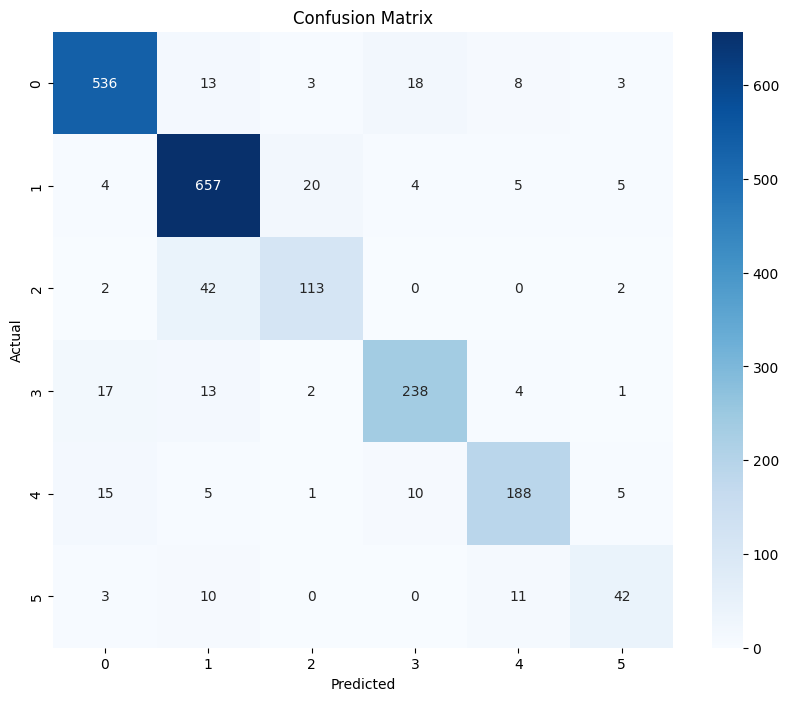

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Import the SVM classifier
from sklearn.svm import SVC

# Create the SVM model
svm_classifier = SVC(kernel='rbf')

# Train the model using the training data
svm_classifier.fit(x_train, y_train)

# Predict on the validation data
y_pred_val = svm_classifier.predict(x_val)

# Evaluate the performance on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.8675


In [ ]:
y_pred_test = svm_classifier.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8685


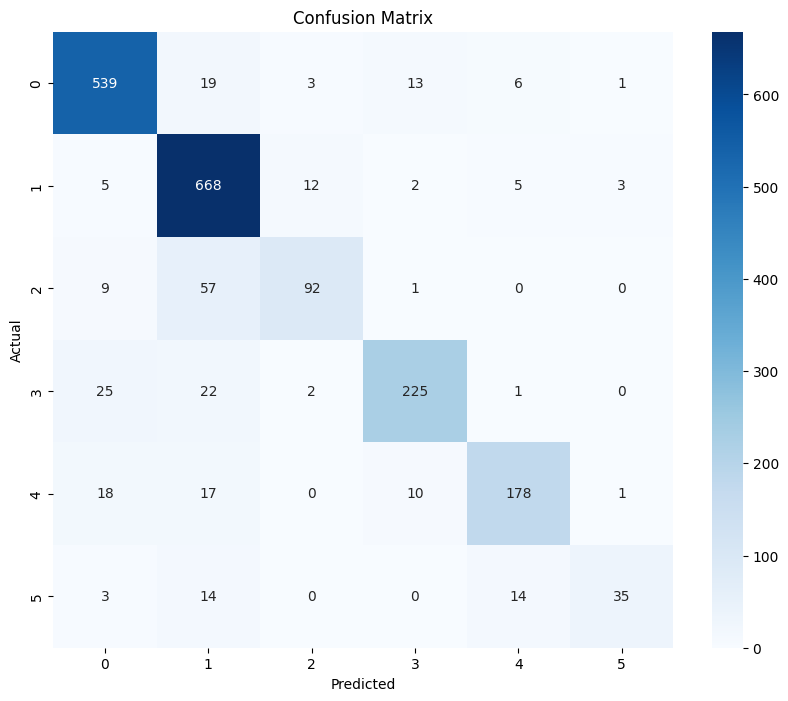

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Import the SVM classifier
from sklearn.svm import SVC

# Create the SVM model
svm_classifier = SVC(kernel='sigmoid')

# Train the model using the training data
svm_classifier.fit(x_train, y_train)

# Predict on the validation data
y_pred_val = svm_classifier.predict(x_val)

# Evaluate the performance on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.8935


In [ ]:
y_pred_test = svm_classifier.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.885


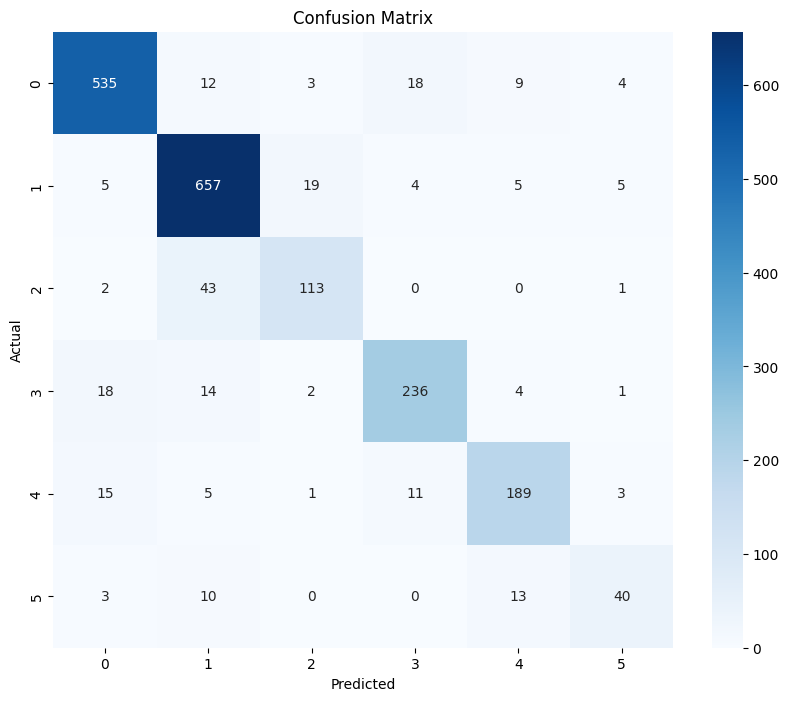

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
checkpoint = ModelCheckpoint('lstm_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
model = Sequential()
model.add(Embedding(16000, 100, input_length=66))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(16000, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(train_X, train_y_one_hot, epochs=25, verbose=1,validation_data=(val_X,val_y_one_hot),callbacks=[checkpoint])
#print model.summary()
print(model)

Epoch 1/25
500/500 [==============================] - ETA: 0s - loss: 1.8466 - accuracy: 0.3188
Epoch 1: val_accuracy improved from -inf to 0.35200, saving model to lstm_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 220s 425ms/step - loss: 1.8466 - accuracy: 0.3188 - val_loss: 1.6162 - val_accuracy: 0.3520
Epoch 2/25
500/500 [==============================] - ETA: 0s - loss: 1.5954 - accuracy: 0.3192
Epoch 2: val_accuracy did not improve from 0.35200
500/500 [==============================] - 213s 427ms/step - loss: 1.5954 - accuracy: 0.3192 - val_loss: 1.5984 - val_accuracy: 0.3520
Epoch 3/25
500/500 [==============================] - ETA: 0s - loss: 1.5915 - accuracy: 0.3217
Epoch 3: val_accuracy did not improve from 0.35200
500/500 [==============================] - 216s 431ms/step - loss: 1.5915 - accuracy: 0.3217 - val_loss: 1.6025 - val_accuracy: 0.3520
Epoch 4/25
500/500 [==============================] - ETA: 0s - loss: 1.5867 - accuracy: 0.3220
Epoch 4: val_accuracy did not improve from 0.35200
500/500 [==============================] - 220s 440ms/step - loss: 1.5867 - accuracy: 0.3220 - val_loss: 1.6021 - val_accuracy: 0.3480
Epoch 5/25
500/500 

In [ ]:
best_model = load_model('lstm_model.h5')

In [ ]:
last_accuracy = "{:.3f}".format(history.history['accuracy'][-1])
print("Training Accuracy:", last_accuracy)

Training Accuracy: 0.994


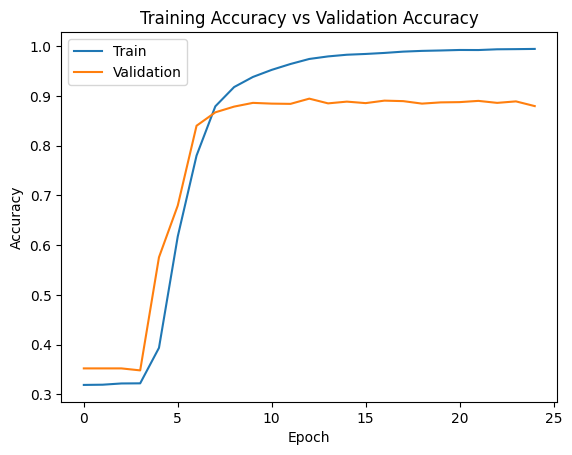

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

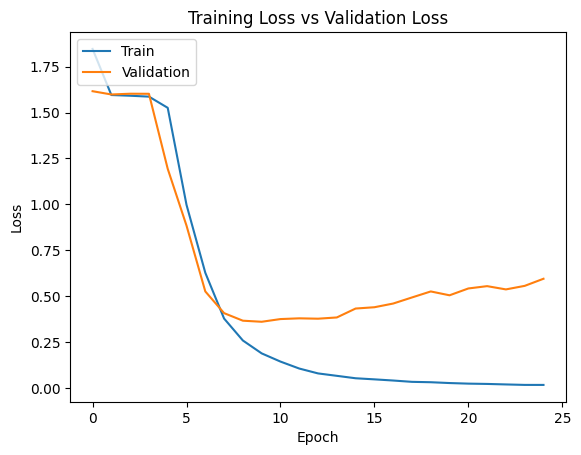

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
def get_text(text):
    tokenizer3 = Tokenizer()
    tokenizer3.fit_on_texts(text)
    word_index3 = tokenizer3.word_index

    stemmed_wordss = [stemmer.stem(word) for word in word_index3.keys()]

    tokens_list= tokenizer2.texts_to_sequences([stemmed_wordss])[0]

    for i in range(len(tokens_list)):
        for j in range(length_of_longest_sentence-len(tokens_list)):
            tokens_list.append(0)
    return tokens_list

In [ ]:
for _ in range(5):
    random_number = random.randint(0, 1000)
    num_to_predicte = random_number

    test = get_text([test_data['text'][num_to_predicte]])

    test = np.array(test)
    test = test.reshape(1, len(test))

    # Make predictions
    predictions = model.predict(test)

    predicted_class = np.argmax(predictions)
    print()
    print('Random value = ',random_number)
    print("Predicted Class:", predicted_class,labels_dict.get(predicted_class))
    print("Actual Class:", test_data['label'][num_to_predicte])
    print()

1/1 [==============================] - 1s 1s/step

Random value =  692
Predicted Class: 4 fear
Actual Class: 4

1/1 [==============================] - 0s 42ms/step

Random value =  715
Predicted Class: 2 love
Actual Class: 2

1/1 [==============================] - 0s 43ms/step

Random value =  158
Predicted Class: 3 anger
Actual Class: 3

1/1 [==============================] - 0s 42ms/step

Random value =  529
Predicted Class: 2 love
Actual Class: 2

1/1 [==============================] - 0s 50ms/step

Random value =  265
Predicted Class: 1 joy
Actual Class: 2



In [ ]:
new_test_data=preprocess_data(test_data)

test_X = [row[0] for row in new_train_data]
test_y = [row[1] for row in new_train_data]

for i in range(len(test_X)):
    for j in range(length_of_longest_sentence-len(test_X[i])):
        test_X[i].append(0)

test_X = np.array(test_X)
test_y = np.array(test_y)

test_y_one_hot = to_categorical(test_y, num_classes=16000)

In [ ]:
y_pred = best_model.predict(test_X)
y_pred_classes = np.argmax(y_pred, axis=1)

500/500 [==============================] - 48s 94ms/step


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Assuming test_y contains the true labels for the test data
accuracy = accuracy_score(test_y, y_pred_classes)
f1 = f1_score(test_y, y_pred_classes, average='macro')
recall = recall_score(test_y, y_pred_classes, average='macro')
precision = precision_score(test_y, y_pred_classes, average='macro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)


Accuracy: 0.9848115507219202
F1 Score: 0.9752817785666356
Recall: 0.9769659609526523
Precision: 0.9739035135773356


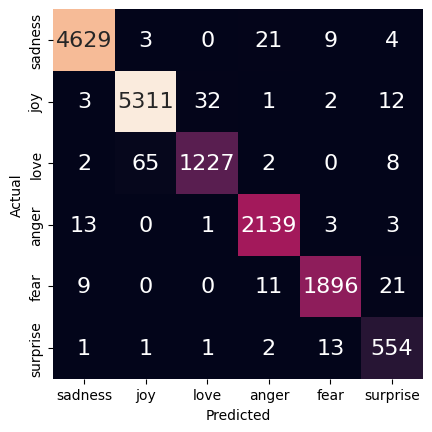

In [ ]:
y_true_labels = np.argmax(test_y_one_hot, axis=1)

labels=['sadness','joy','love','anger','fear','surprise']
#labels = list(set(labels).intersection(set(np.unique(y_true_labels)).union(set(np.unique(y_pred_classes)))))

cm = confusion_matrix(y_true_labels, y_pred_classes)
df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={'size': 16}, square=True, cbar=False, fmt='d')
ax.set_ylim(0, 6)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.invert_yaxis()
plt.show()

